In [34]:
%load_ext autoreload
%autoreload 2

## Fist, get the HTML

In [35]:
import requests
page = requests.get('http://www.radical-production.fr/concerts/')
page_content = page.text
#page_content = open('samples/toutpartout.be.snippet.shows_search.php.html').read()

We can list the repeating tagpaths, with or without classes or HTML IDs:

In [62]:
from collections import Counter
from sketchtml.repeats import TagPathClustering


clustering = TagPathClustering(page_content,
                               with_id=False,
                               with_classes=True,
                               strip_digits=True,
                               ignore_classes=('active', 'soldout'),
                               text_only=False
                              )
clustering._build_tagpaths()

for tp, cnt in Counter(clustering.tagpaths).most_common():
    if cnt > 1:
        print('({:3d}) {}'.format(cnt, tp))

( 80) /html/body.*page.*page-id-.*page-template-default.*safari/div/div/div.container/div/div/div/div/div/div.clearfix/div/div/div.clearfix.entry.post/p/code/table.gigpress-table.upcoming/tbody.vevent/tr.gigpress-row/td.gigpress-venue.location
( 80) /html/body.*page.*page-id-.*page-template-default.*safari/div/div/div.container/div/div/div/div/div/div.clearfix/div/div/div.clearfix.entry.post/p/code/table.gigpress-table.upcoming/tbody.vevent/tr.gigpress-info/td.gigpress-links-cell/div.gigpress-calendar-add/div.gigpress-calendar-links/div.gigpress-calendar-links-inner/span
( 80) /html/body.*page.*page-id-.*page-template-default.*safari/div/div/div.container/div/div/div/div/div/div.clearfix/div/div/div.clearfix.entry.post/p/code/table.gigpress-table.upcoming/tbody.vevent/tr.gigpress-info/td.gigpress-links-cell/div.gigpress-calendar-add/div.gigpress-calendar-links/div.gigpress-calendar-links-inner/span/a
( 69) /html/body.*page.*page-id-.*page-template-default.*safari/div/div/div.container/

## Clustering of tagpaths

Perform spectral clustering using the methom from ["Extracting Data Records from the Web Using Tag Path Clustering", 2009](http://www2009.wwwconference.org/proceedings/pdf/p981.pdf).

> Miao, Gengxin & Tatemura, Junichi & Hsiung, Wang-Pin & Sawires, Arsany & Moser, Louise. (2009).
> **Extracting data records from the Web using tag path clustering**. ACM WWW. 981-990. 10.1145/1526709.1526841.

In [63]:
clusters = clustering.clusters()

In [64]:
sorted(set(clustering.tagpaths))

['/html',
 '/html/body.*page.*page-id-.*page-template-default.*safari',
 '/html/body.*page.*page-id-.*page-template-default.*safari/div',
 '/html/body.*page.*page-id-.*page-template-default.*safari/div/a',
 '/html/body.*page.*page-id-.*page-template-default.*safari/div/div',
 '/html/body.*page.*page-id-.*page-template-default.*safari/div/div.clearfix',
 '/html/body.*page.*page-id-.*page-template-default.*safari/div/div.clearfix.container',
 '/html/body.*page.*page-id-.*page-template-default.*safari/div/div.clearfix.container/div',
 '/html/body.*page.*page-id-.*page-template-default.*safari/div/div.clearfix.container/div/form',
 '/html/body.*page.*page-id-.*page-template-default.*safari/div/div.clearfix.container/div/form/input',
 '/html/body.*page.*page-id-.*page-template-default.*safari/div/div.clearfix.container/ul.nav',
 '/html/body.*page.*page-id-.*page-template-default.*safari/div/div.clearfix.container/ul.nav/li',
 '/html/body.*page.*page-id-.*page-template-default.*safari/div/di

## Plotting tagpaths "signals" can help chosing better `with_classes`, `with_ids` parameters

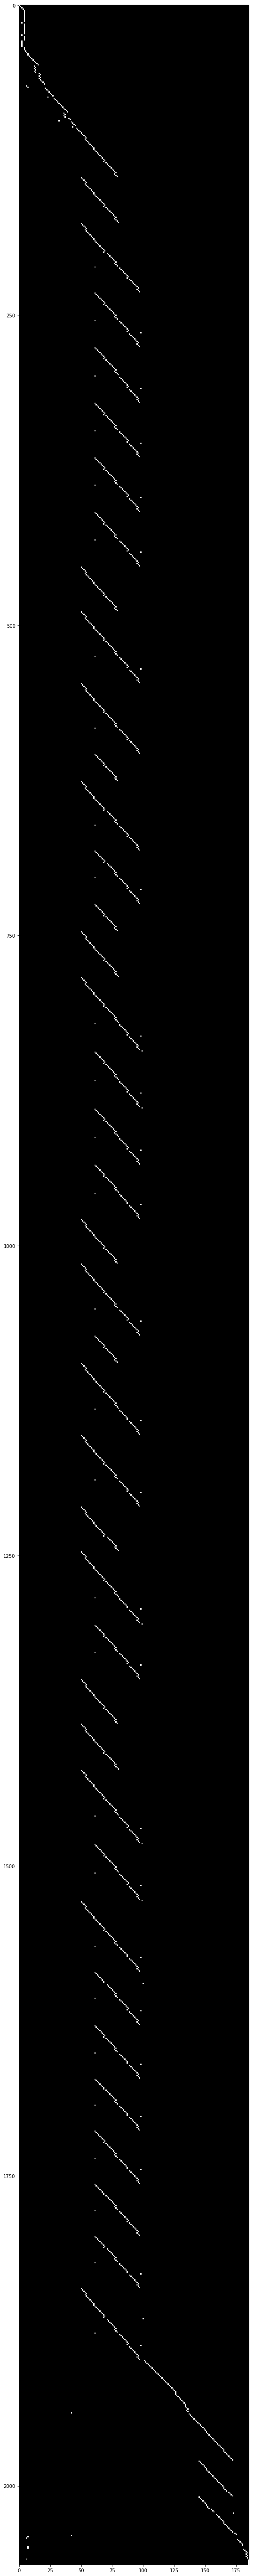

In [65]:
clustering.simhelper.plot_signals()

In [67]:
from pprint import pprint as pp

pp(clusters)

defaultdict(<class 'list'>,
            {0: ['/html/body.*page.*page-id-.*page-template-default.*safari/div/div/div.container/div/div/div/div/div/div.clearfix/div/div/div.clearfix.entry.post/p/code/table.gigpress-table.upcoming/tbody.vevent/tr.gigpress-alt.gigpress-info',
                 '/html/body.*page.*page-id-.*page-template-default.*safari/div/div/div.container/div/div/div/div/div/div.clearfix/div/div/div.clearfix.entry.post/p/code/table.gigpress-table.upcoming/tbody.vevent/tr.gigpress-alt.gigpress-info/td.description',
                 '/html/body.*page.*page-id-.*page-template-default.*safari/div/div/div.container/div/div/div/div/div/div.clearfix/div/div/div.clearfix.entry.post/p/code/table.gigpress-table.upcoming/tbody.vevent/tr.gigpress-alt.gigpress-info/td.gigpress-links-cell',
                 '/html/body.*page.*page-id-.*page-template-default.*safari/div/div/div.container/div/div/div/div/div/div.clearfix/div/div/div.clearfix.entry.post/p/code/table.gigpress-table.upcoming

## Let's build a trie to reconstruct the layout from a tagpath list (from one or more clusters or a chosen subset of tagpaths)

In [68]:
from functools import partial
from typing import Tuple
from pprint import pformat

_node_repr = partial(TagPathClustering.node_repr,
                             with_classes=True,
                             with_id=False,
                             with_attr_names=False,
                             strip_digits=False)
_node_repr = clustering._node_repr
# This if borrowed from https://towardsdatascience.com/implementing-a-trie-data-structure-in-python-in-less-than-100-lines-of-code-a877ea23c1a1

class TrieNode(object):
    """
    Our trie node implementation. Very basic. but does the job
    """
    
    def __init__(self, char_repr):
        self.char_repr = char_repr
        self.elements = set()
        self.children = []
        # Is it the last character of the word.`
        self.word_finished = False
        # How many times this character appeared in the addition process
        self.counter = 1

def add(root, word):
    """
    Adding a word in the trie structure
    """
    node = root
    #print('Root: {}, Word: {}'.format(root, word))
    for char in word:
        char_repr = _node_repr(char)
        #print('Char: {}'.format(char_repr))
        found_in_child = False
        # Search for the character in the children of the present `node`
        for child in node.children:
            if child.char_repr == char_repr:
                # We found it, increase the counter by 1 to keep track that another
                # word has it as well
                child.counter += 1
                # And point the node to the child that contains this char
                node = child
                found_in_child = True
                #print('Child found.')
                node.elements.add(char)
                break
        # We did not find it so add a new chlid
        if not found_in_child:
            new_node = TrieNode(char_repr)
            new_node.elements.add(char)
            node.children.append(new_node)
            # And then point node to the new child
            node = new_node
            #print('Child NOT found. Creating new TrieNode({})'.format(char))
    # Everything finished. Mark it as the end of a word.
    node.word_finished = True

To help chose the clusters we need, we can print out some of the text data for each tagpath in each cluster.

In [69]:
from pprint import pprint

for n, cluster in sorted(clusters.items()):
    if len(cluster) < 0:
        continue

    print('---- Cluster #{} ----'.format(n))
    for tp in sorted(cluster, key=lambda tp: tp.split('/')):
        to_print = []
        try:
            for nodepath in clustering.tagpath_nodes[tp][:10]:
                node = nodepath[-1]
                e = node.element
                texts = [s.strip() for s in e.xpath('./text()[normalize-space()]')]
                attribs = {k: v for k, v in e.attrib.items() if k not in ['class']}
                t = ' '.join(texts)[:100]
                if t or attribs:
                #if t:
                    to_print.append((node.doc_order, t, attribs))
            if to_print:
                print('---\n'+tp)
                for e in to_print:
                    print(e)
                print()
        except Exception as e:
            print(str(e))
            pass

---- Cluster #0 ----
---
/html/body.*page.*page-id-.*page-template-default.*safari/div/div/div.container/div/div/div/div/div/div.clearfix/div/div/div.clearfix.entry.post/p/code/table.gigpress-table.upcoming/tbody.vevent/tr.gigpress-alt.gigpress-info/td.description
(254, '', {'colspan': '3'})
(298, '', {'colspan': '3'})
(343, '', {'colspan': '3'})
(387, '', {'colspan': '3'})
(431, '', {'colspan': '3'})
(475, '', {'colspan': '3'})
(569, '', {'colspan': '3'})
(626, '', {'colspan': '3'})
(704, '', {'colspan': '3'})
(747, '', {'colspan': '3'})

---
/html/body.*page.*page-id-.*page-template-default.*safari/div/div/div.container/div/div/div/div/div/div.clearfix/div/div/div.clearfix.entry.post/p/code/table.gigpress-table.upcoming/tbody.vevent/tr.gigpress-alt.gigpress-info/td.gigpress-links-cell/div.gigpress-calendar-add/a.gigpress-links-toggle
(247, 'Add', {'href': '#calendar-links-1831'})
(291, 'Add', {'href': '#calendar-links-1846'})
(336, 'Add', {'href': '#calendar-links-1847'})
(380, 'Add'

In [70]:
root = TrieNode('')
nodelists = clustering.tagpath_nodes
tps = []
for i in [0,1,5,6,7]:
    for tp in clusters[i]:
        tps.append(tp)
tps

['/html/body.*page.*page-id-.*page-template-default.*safari/div/div/div.container/div/div/div/div/div/div.clearfix/div/div/div.clearfix.entry.post/p/code/table.gigpress-table.upcoming/tbody.vevent/tr.gigpress-alt.gigpress-info',
 '/html/body.*page.*page-id-.*page-template-default.*safari/div/div/div.container/div/div/div/div/div/div.clearfix/div/div/div.clearfix.entry.post/p/code/table.gigpress-table.upcoming/tbody.vevent/tr.gigpress-alt.gigpress-info/td.description',
 '/html/body.*page.*page-id-.*page-template-default.*safari/div/div/div.container/div/div/div/div/div/div.clearfix/div/div/div.clearfix.entry.post/p/code/table.gigpress-table.upcoming/tbody.vevent/tr.gigpress-alt.gigpress-info/td.gigpress-links-cell',
 '/html/body.*page.*page-id-.*page-template-default.*safari/div/div/div.container/div/div/div/div/div/div.clearfix/div/div/div.clearfix.entry.post/p/code/table.gigpress-table.upcoming/tbody.vevent/tr.gigpress-alt.gigpress-info/td.gigpress-links-cell/div.gigpress-calendar-add

In [25]:
tps = '''/html/body/form/table/tbody/tr/td/div/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/div/table/tbody/tr/td/div/table/tbody/tr/td/table/tbody/tr/td/div/div/div/div/table/tbody/tr/td/a
/html/body/form/table/tbody/tr/td/div/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/div/table/tbody/tr/td/div/table/tbody/tr/td/table/tbody/tr/td/div/div/div/table/tbody/tr/td/table/tbody/tr/td/div/table/tbody/tr/td/table/tbody/tr/td/a
/html/body/form/table/tbody/tr/td/div/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/div/div/div/table/tbody/tr/td/div/table/tbody/tr/td/div/table/tbody/tr/td/a
/html/body/form/table/tbody/tr/td/div/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/div/table/tbody/tr/td/div/table/tbody/tr/td/div/table/tbody/tr/td/div/div/div/span/a
/html/body/form/table/tbody/tr/td/div/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/div/table/tbody/tr/td/div/div/div/a
/html/body/form/table/tbody/tr/td/div/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/div/table/tbody/tr/td/div/div/a
/html/body/form/table/tbody/tr/td/div/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/div/div/div/table/tbody/tr/td/div/div/div/div/table/tbody/tr/td/a
/html/body/form/table/tbody/tr/td/div/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/div/table/tbody/tr/td/div/div/div/div/div/div/div/a
/html/body/form/table/tbody/tr/td/div/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/table/tbody/tr/td/div/div/div/div/div/table/tbody/tr/td/a
'''.splitlines()

Now let's insert them into the trie:

In [71]:
root = TrieNode('')
nodelists = clustering.tagpath_nodes
for tp in clustering.tagpath_nodes.keys():
    steps = tp.lstrip('/').split('/')
    for nl in nodelists[tp][:]:
        add(root, nl)

In [72]:
def layout(node, summary=True):
    return dict(
        tag=node.char_repr if node.char_repr else node.char_repr,
        element=len(set(node.elements)) if summary else set(node.elements),
        children=[layout(c, summary=summary) for c in node.children],
        word_finished=node.word_finished
    )

If we check the general structure of the trie, we can notice that some levels only have 1 child.

In [73]:
def collapse(trienode):
    for c in trienode.children:
        collapse(c)
    if len(trienode.children) == 1 and not trienode.word_finished:
        trienode.char_repr += '/'+trienode.children[0].char_repr
        trienode.elements = trienode.children[0].elements
        
        trienode.children = trienode.children[0].children

In [74]:
collapse(root)
layout(root)

{'tag': '/html',
 'element': 1,
 'children': [{'tag': 'head',
   'element': 1,
   'children': [{'tag': 'meta',
     'element': 8,
     'children': [],
     'word_finished': True},
    {'tag': 'title', 'element': 1, 'children': [], 'word_finished': True},
    {'tag': 'link', 'element': 26, 'children': [], 'word_finished': True}],
   'word_finished': True},
  {'tag': 'body.*page.*page-id-.*page-template-default.*safari',
   'element': 1,
   'children': [{'tag': 'div',
     'element': 4,
     'children': [{'tag': 'div',
       'element': 6,
       'children': [{'tag': 'div',
         'element': 1,
         'children': [],
         'word_finished': True},
        {'tag': 'div.container',
         'element': 1,
         'children': [{'tag': 'div',
           'element': 2,
           'children': [{'tag': 'a',
             'element': 1,
             'children': [{'tag': 'div',
               'element': 1,
               'children': [{'tag': 'img',
                 'element': 1,
              

We can collapse those branches:

The trie also keeps references to individual HTML nodes, with their document order so that we can re-build the data hierarchy:

In [75]:
layout(root, summary=False)

{'tag': '/html',
 'element': {Node(tag='html', doc_order=2, child_position=1, attribs={'xmlns': 'http://www.w3.org/1999/xhtml', 'lang': 'fr-FR'}, element=<Element html at 0x7f44ed44bfc8>)},
 'children': [{'tag': 'head',
   'element': {Node(tag='head', doc_order=3, child_position=1, attribs={'profile': 'http://gmpg.org/xfn/11'}, element=<Element head at 0x7f44ff7b0848>)},
   'children': [{'tag': 'meta',
     'element': {Node(tag='meta', doc_order=4, child_position=1, attribs={'http-equiv': 'Content-Type', 'content': 'text/html; charset=UTF-8'}, element=<Element meta at 0x7f45020d1148>),
      Node(tag='meta', doc_order=17, child_position=2, attribs={'content': 'RADICAL PRODUCTION v.1.0', 'name': 'generator'}, element=<Element meta at 0x7f450202fc48>),
      Node(tag='meta', doc_order=35, child_position=3, attribs={'name': 'generator', 'content': 'WordPress 3.7.28'}, element=<Element meta at 0x7f450681a148>),
      Node(tag='meta', doc_order=44, child_position=4, attribs={'name': 'et_fea

## Re-creating data hierarchy

Below is the most interesting bit: how to re-create a dict/JSON document from repeating tagpaths.

Using the trie, from the root of the tree, we loop over all HTML elements of a trie node, and recursively collect data from its children:

In [78]:
from collections import defaultdict
from operator import itemgetter
from lxml.html import tostring


def hydrate(node, docorder_min, docorder_max=None, include_html=False):
    elements = sorted(set(node.elements), key=lambda n: n.doc_order)
    output = []

    for i, element in enumerate(elements, start=1):
        
        # filter out elements that are not within the parent document order range
        if not (docorder_min < element.doc_order):
            continue
        if (docorder_max is not None) and (element.doc_order > docorder_max):
            continue
        
        # here's where you extract data from the element
        # 1. node representation including tag and classes can tell us a bit about what it's about
        # 2. document order is purely informational
        # 3. child text nodes usually contain much of the information we want
        # 4. element attributes also can be useful (URL, data-* etc.)
        e = {'tag': _node_repr(element),
             '_doc_order': element.doc_order}
        
        # textual information
        _t = list(filter(bool, [t.strip() for t in element.element.xpath('./text()[normalize-space()]')]))
        if _t:
            e['text'] = _t[0] if len(_t) == 1 else _t
        _html = tostring(element.element, encoding='unicode')
        if _html:
            #e['html'] = _html
            pass
            
        _attrib = dict(element.element.attrib)
        if 'class' in _attrib:
            _attrib.pop('class')
        if _attrib:
            e['_attr'] = _attrib
        
        # loop through sub-nodes that are between the current node and the next one
        # Warning: recursivity!
        _order_min = element.doc_order
        if i < len(elements):
            _order_max = elements[i].doc_order
        else:
            _order_max = None
        children = list(filter(bool, [c for child in node.children
                                      for c in hydrate(child, _order_min, _order_max)]))
        if children:
            e['children'] = sorted(children, key=itemgetter('_doc_order'))
            #e['children'] = children
        
        # if there's not "valuable" information, might as well skip the element
        if 'children' not in e and not(any(e.get(k) for k in ['text', '_attr'])):
            continue

        output.append(e)
        
    #return sorted(output, key=itemgetter('_doc_order'))
    return output

output = hydrate(root, 0)
output

[{'tag': 'html',
  '_doc_order': 2,
  '_attr': {'xmlns': 'http://www.w3.org/1999/xhtml', 'lang': 'fr-FR'},
  'children': [{'tag': 'head',
    '_doc_order': 3,
    '_attr': {'profile': 'http://gmpg.org/xfn/11'},
    'children': [{'tag': 'meta',
      '_doc_order': 4,
      '_attr': {'http-equiv': 'Content-Type',
       'content': 'text/html; charset=UTF-8'}},
     {'tag': 'title',
      '_doc_order': 5,
      'text': 'Radical Production | Concerts rock'},
     {'tag': 'link',
      '_doc_order': 6,
      '_attr': {'rel': 'stylesheet',
       'href': 'http://www.radical-production.fr/wp-content/themes/radical/style.css',
       'type': 'text/css',
       'media': 'screen'}},
     {'tag': 'link',
      '_doc_order': 7,
      '_attr': {'rel': 'stylesheet',
       'href': 'http://www.radical-production.fr/wp-content/themes/radical/css/colorpicker.css',
       'type': 'text/css',
       'media': 'screen'}},
     {'tag': 'link',
      '_doc_order': 8,
      '_attr': {'href': 'http://fonts.goo

The output data seems to present all the data we'd need for something like PyVideo.org.

Let's just save for further processing.

In [24]:
import json

JSON_FORMAT_KWARGS = {
    'indent': 2,
    'separators': (',', ': '),
    'sort_keys': True,
}
with open('pydata-berlin-2015.speakers.json', 'w') as fp:
    json.dump(output, fp, **JSON_FORMAT_KWARGS)
    fp.write("\n")

## Is there a way to automatically chose clusters?

Spectral clustering does not always give the "best" results. It may be due to the similarity function, or some other parameters, I don't know yet really.

Below is a just to see if hierarchical clustering of tagpaths would do a better job.

In [62]:
simhelper = clustering.simhelper

In [63]:
from itertools import zip_longest, combinations
from collections import Counter

import numpy as np

tagpaths = [
    tp for tp, cnt in Counter(clustering.tagpaths).most_common()
    if cnt > 1
]

l = len(tagpaths)
matrix = np.zeros((l, l))

for a, b in combinations(tagpaths, 2):
    ia, ib = tagpaths.index(a), tagpaths.index(b)
    try:
        matrix[ia, ib] = 1 - simhelper.similarity(a, b, epsilon=10)
    except:
        matrix[ia, ib] = 1
    matrix[ib, ia] = matrix[ia, ib]
    matrix[ia, ia] = 0
    matrix[ib, ib] = 0

In [64]:
from sklearn.cluster import AgglomerativeClustering

clustering2 = AgglomerativeClustering(n_clusters=l, affinity='precomputed', linkage='average')

clustering2.fit_predict(matrix)

array([237, 156, 236, 235, 245, 241, 147, 215, 231, 137, 229, 234, 167,
       233, 126, 232, 227, 228, 230, 145, 190, 244, 193, 243, 242, 141,
       214, 217, 212, 194, 218, 211, 186, 219, 209, 220, 160, 195, 124,
       189, 221, 201, 222, 142, 196, 185, 223, 208, 224,  97, 192, 225,
       210, 226, 110, 148, 216, 176, 107, 104, 213, 182, 240, 120, 136,
       199, 173, 135, 207, 150, 127, 200,  94, 203, 191, 204, 171, 198,
       205, 184, 164, 169, 206, 105,  99, 202,  92, 100,  96, 197, 116,
       172, 109, 151, 179, 188, 187, 183,  91,  93, 163, 149, 159, 175,
       181,  87, 180, 146,  89,  67, 165, 106, 177, 162, 178, 166, 123,
       174, 102, 158,  86, 238,  85,  98, 117, 170, 138,  84,  73, 168,
       132,  83,  95, 118, 103,  81, 112, 239, 161,  82,  80,  68,  79,
       115,  39, 157, 140, 129, 154,  90, 155,  57,  77,  52,  44, 143,
       139,  49, 131, 153,  58,  48, 101,  42, 152,  51,  75, 114,  74,
        45,  36, 122, 121,  50, 111,  78,  69,  46,  72,  41, 14

In [29]:
# Authors: Mathew Kallada
# License: BSD 3 clause
"""
=========================================
Plot Hierarachical Clustering Dendrogram 
=========================================

This example plots the corresponding dendrogram of a hierarchical clustering
using AgglomerativeClustering and the dendrogram method available in scipy.
"""

import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

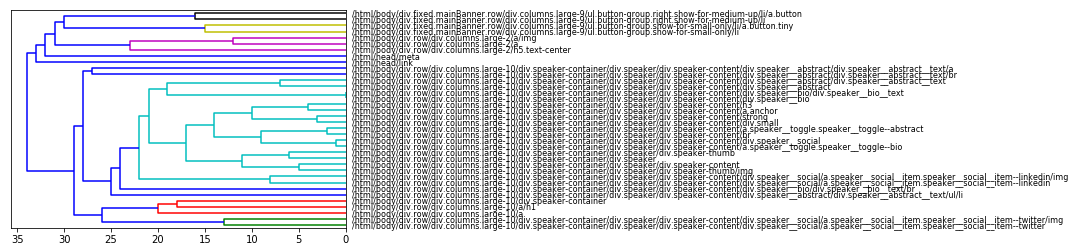

In [30]:
ax = plt.plot()
plot_dendrogram(clustering2, labels=tagpaths, orientation='left'
                , leaf_font_size=8
               )